array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f5b631ea390>], dtype=object)

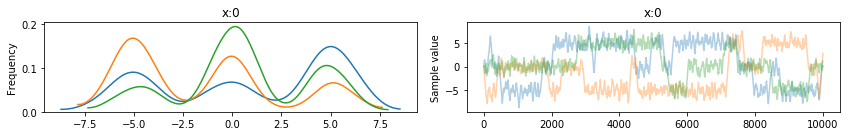

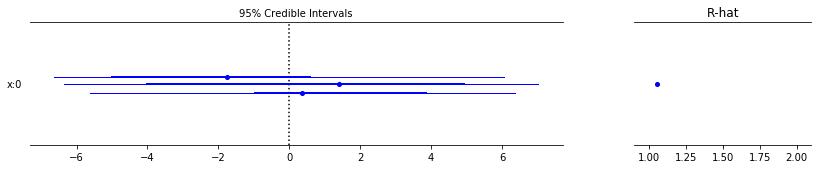

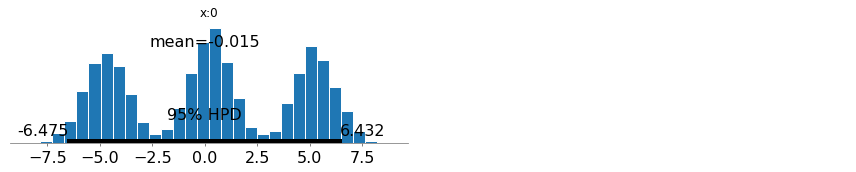

In [22]:
%matplotlib inline
import sys
import os
sys.path.insert(0, os.path.join(os.path.abspath("."), "..", "..", ".."))

from pysgmcmc.diagnostics.sample_chains import PYSGMCMCTrace, pymc3_multitrace
from pymc3.backends.base import MultiTrace
from pymc3.diagnostics import effective_n as ess

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from pysgmcmc.samplers.relativistic_sghmc import RelativisticSGHMCSampler
from pymc3.plots import *

from pysgmcmc.diagnostics.objective_functions import (
    banana_log_likelihood,
    gmm1_log_likelihood, gmm2_log_likelihood,
    gmm3_log_likelihood
)

from pysgmcmc.samplers.relativistic_sghmc import RelativisticSGHMCSampler
from pysgmcmc.stepsize_schedules import ConstantStepsizeSchedule

from collections import namedtuple
from itertools import islice

ObjectiveFunction = namedtuple(
    "ObjectiveFunction", ["function", "dimensionality"]
)

objective_functions = (
    ObjectiveFunction(
        function=gmm1_log_likelihood, dimensionality=1
    ),
)


def cost_function(log_likelihood_function):
    def wrapped(*args, **kwargs):
        return -log_likelihood_function(*args, **kwargs)
    wrapped.__name__ = log_likelihood_function.__name__
    return wrapped

def sampler_generator(function):
    def get_sampler(session):
        if function.__name__ == "banana_log_likelihood":
            params = [
                tf.Variable(0., dtype=tf.float32, name="x"), 
                tf.Variable(6., dtype=tf.float32, name="y")
            ]
        else:
            params = [tf.Variable(0., dtype=tf.float32, name="x")]
        sampler = RelativisticSGHMCSampler(
            stepsize_schedule=ConstantStepsizeSchedule(0.1),
            params=params, 
            cost_fun=cost_function(function), 
            session=session,
            dtype=tf.float32
        )
        session.run(tf.global_variables_initializer())
        return sampler
    return get_sampler

mt = pymc3_multitrace(sampler_generator(objective_functions[0][0]), n_chains=3, samples_per_chain=10000)
traceplot(mt)
autocorrplot(mt)
forestplot(mt)
plot_posterior(mt)